# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

# Student exchange in Toronto

![texte](https://gossee.com/wp-content/uploads/2017/07/toronto-1920x900.jpg)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Every year hundreds of students from around the world conduct school exchanges in the city of Toronto.
They are people from the most different kinds of cities, and most of them don't have a clue about what is to live in Toronto.
Typically, college students desire to live in places near bus stops, subway stations, convenience stores, markets, and preferably close to the university. 
With this in mind, I intend to use Foursquare API data to indicate the most suitable neighborhoods to live in during the exchange.
Also, I want to rank the neighborhoods with the highest crime rates, that maybe newbies in the city should take extra care.


This project helps the end user to not only recommend but also saves a lot of time in manual search. This will save the time and money of the user. It can be used by the user at the time of rental apartment or buy house in a locality based on the distribution of various facilities available around the neighborhood. As an example, this project would compare neighborhoods and analyses the top 10 most suitable, based at the distribution of bus stops, convenience stores, train stations, supermarkets, parks, pharmacys and universities. Also, this project uses K-means clustering unsupervised machine learning algorithm to cluster the neighborhoods based on the venues distribution such as restaurants, park, coffee shop, gym, clubs etc. This would give a better understanding of the similarities and dissimilarities between the neighborhoods to retrieve more insights and to conclude with ease which neighborhood will be more suitable.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Mean value for Bus Stations, Bus Stops, Convenience Stores, Train Stations, Markets, Parks, Pharmacys, Supermarkets and Universitys nearby;
* Crime rate based on Major Crime Indicator dataset.

Following data sources will be needed to extract/generate the required information:
* All Toronto neighbords latitude and longitude, using **BeautifulSoup** and IBM/Coursera Geospatial dataset provided in previous labs
* Every venue within 1 km from each neighborhood in Toronto using **Foursquare API**

## Python packages and Dependencies:


* Pandas – Library for Data Analysis   
* NumPy – Library to handle data in a vectorized manner   
* BeautifulSoup – to retrieve data from an HTML table   
* JSON – Library to handle JSON files    
* Geopy – To retrieve Location Data    
* Requests – Library to handle http requests   
* Matplotlib – Python Plotting Module    
* Sklearn – Python machine learning Library    
* Folium – Map rendering Library   

# Generating data

### First, let's get ready with all packages

In [15]:
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML     
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 

print('Libraries imported.\nAll set.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

### Extracting Toronto nighborhoods data

In [3]:
data_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
lat_long = pd.DataFrame(pd.read_csv('https://cocl.us/Geospatial_data'))
lat_long.sort_values('Postal Code', inplace=True)
page = requests.get(data_url)
soup = BeautifulSoup(page.text, 'html.parser')

In [4]:
data = []

for i in range(0,289):
    a = soup.find_all('tr')[i].text
    if not a is None:
        a = a.strip()
        a = a.replace('\n', ',').split(',')
    data.append(a)
    
df_wiki = pd.DataFrame(data)
new_header = ['Postcode', 'Borough', 'Neighborhood'] 
df_wiki = df_wiki[1:] 
df_wiki.columns = new_header 

df_wiki['Neighborhood'] = np.where(df_wiki['Neighborhood'] == 'Not assigned', df_wiki['Borough'], df_wiki['Neighborhood'])
df_wiki.replace('Not assigned', np.nan, inplace=True)
df_wiki.dropna(0, inplace=True)
df_wiki.sort_values('Postcode', inplace=True)
df_wiki.reset_index(inplace=True)
df_wiki.drop('index', axis=1, inplace=True)

df_wiki = df_wiki.merge(lat_long, how='left', left_on='Postcode', right_on='Postal Code')
toronto_df = df_wiki.drop(['Postal Code'], 1)
print('Data ready!')
toronto_df.head()

Data ready!


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1B,Scarborough,Malvern,43.806686,-79.194353
2,M1C,Scarborough,Port Union,43.784535,-79.160497
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497


### Foursquare API

#### Getting all venue names within 1km from each neighborhood

In [5]:
CLIENT_ID = 'Q51OTGXMG3I05N0XMXVPRVSHENSNNXATPCU4JPAMKNSL5GIT' # your Foursquare ID
CLIENT_SECRET = '1FI0XL43TIPKMIX3WXATATRLP2AWNRYY3FMI01A10F0J3HTG' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 500

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
api_data = pd.DataFrame()

for i in range(toronto_df.size):
    try:
        latitude = toronto_df['Latitude'][i]
        longitude = toronto_df['Longitude'][i]
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues  = json_normalize(venues)
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.postalCode', 'venue.location.lat', 'venue.location.lng']
        nearby_venues =nearby_venues.loc[:, filtered_columns]
 # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
 # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        nearby_venues['postalCode'] = nearby_venues.postalCode.str.extract('(\w\w\w)',expand=False)
        nearby_venues.replace(np.nan, (nearby_venues['postalCode'].value_counts().index[0]), inplace=True)
        api_data = api_data.append(nearby_venues)

    except:
        pass
    
print('Data processed!')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Data processed!


#### Removing duplicated names


In [6]:
api_sorted = api_data.groupby('name').first().reset_index()
api_sorted.head()

,name,categories,postalCode,lat,lng
0,195 Jane Rocket,Bus Line,M6N,43.672335,-79.492634
1,241 Pizza,Pizza Place,M6N,43.672351,-79.492631
2,306 Yonge Street - Jordan Store,Sporting Goods Shop,M5B,43.656495,-79.381015
3,360 Restaurant,Wine Bar,M5V,43.642537,-79.387042
4,4 Life Natural Foods,Farmers Market,M5T,43.655275,-79.402374


#### Merging API Data with Neighborhood latitude and longitude values

In [7]:
toronto_merge = toronto_df.merge(api_sorted, how='left', left_on='Postcode', right_on='postalCode')
toronto_merge = toronto_merge.dropna(0)
print('There are {} uniques categories.'.format(len(toronto_merge['categories'].unique())))

There are 272 uniques categories.


# Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Berlin that have low restaurant density, particularly those with low number of Italian restaurants. We will limit our analysis to area ~6km around city center.

In first step we have collected the required **data: location and type (category) of every venue within 1 km from each neighborhood**. We have also **ranked the Top5 highest major crime indicators**. 

Second step in our analysis will be calculation and exploration of '**target venues**' mean values across different neighborhoods - we will use **one hot encoding** to identify the best areas.

In third and final step we will find the best neighborhood for you to live in if you want to make an exchange course in toronto!

#### One Hot Encoding

In [8]:
toronto_onehot = pd.get_dummies(toronto_merge[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_merge['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Grouping the one hot enconding by neighboorhood

In [9]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Adelaide,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0,0,0,

In [10]:
num_top_venues = 5
for hood in toronto_grouped['Neighborhood'][::]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
             venue  freq
0            Hotel   4.0
1       Steakhouse   4.0
2  Thai Restaurant   3.0
3              Bar   3.0
4             Café   3.0


----Agincourt----
                       venue  freq
0         Chinese Restaurant   1.0
1                     Lounge   1.0
2             Breakfast Spot   1.0
3  Latin American Restaurant   1.0
4                Yoga Studio   0.0


----Agincourt North----
                venue  freq
0          Playground   1.0
1                Park   1.0
2    Asian Restaurant   1.0
3         Yoga Studio   0.0
4  Mexican Restaurant   0.0


----Albion Gardens----
                             venue  freq
0                    Grocery Store   2.0
1                      Video Store   1.0
2                      Yoga Studio   0.0
3                      Men's Store   0.0
4  Molecular Gastronomy Restaurant   0.0


----Alderwood----
          venue  freq
0  Dance Studio   1.0
1           Gym   1.0
2           Pub   1.0
3  Skating Rink   1.0
4       

### Listing the most comum venues

In [146]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Steakhouse,Hotel,Bar,Café,Thai Restaurant,Asian Restaurant,Bakery,Salad Place,Japanese Restaurant,Park
1,Agincourt,Breakfast Spot,Lounge,Skating Rink,Clothing Store,Latin American Restaurant,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant
2,Agincourt North,Park,Coffee Shop,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
3,Albion Gardens,Grocery Store,Astrologer,Women's Store,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dumpling Restaurant
4,Alderwood,Gym,Skating Rink,Pizza Place,Pub,Dance Studio,Pool,Women's Store,Discount Store,Department Store,Dessert Shop


## Elbow Curve to find the optimum number of clusters

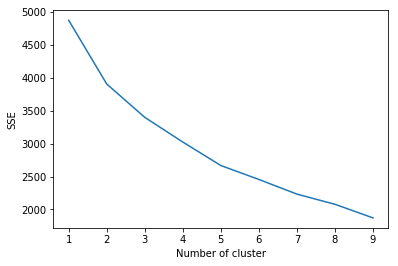

In [11]:
toronto_grouped_cluster = toronto_grouped.drop('Neighborhood', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=12).fit(toronto_grouped_cluster)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [12]:
#from sklearn.preprocessing import StandardScaler
x = toronto_grouped.loc[:,'Yoga Studio':"Women's Store"]
k = 2
k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12, random_state=12377)

#X = np.nan_to_num(X)
#Clus_dataSet = StandardScaler().fit_transform(featureset)
#Clus_dataSet

k_means.fit(x)
labels = k_means.labels_
toronto_grouped['Cluster Labels'] = labels
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Cluster Labels
0,Adelaide,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,2,0,3,0,0,0

#### Add back to Toronto dataset

In [13]:
toronto_merged = toronto_grouped.merge(toronto_df, how='left', left_on='Neighborhood', right_on='Neighborhood')
toronto_merged.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Cluster Labels,Postcode,Borough,Latitude,Longitude
0,Adelaide,0,0,0,0,0,0,0,0,0,1

## Plotting clusters

In [19]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_map = location.latitude
longitude_map = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude_map, longitude_map], zoom_start=12)
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(k)
colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters 

The geograpical coordinate of Toronto are 43.706748299999994, -79.5940544.
['#8000ff', '#ff0000']


## Creating rank of Neighborhoods with best location score

#### Target places as: Bus Station, Bus Stop, Convenience Store, Train Station, Market, Park, Pharmacy and Supermarket

In [21]:
target = ['Bus Station', 'Bus Stop', 'Convenience Store', 'Train Station', 'Market', 'Park', 'Pharmacy', 'Supermarket']

toronto_rank = pd.DataFrame()
toronto_rank[['Borough', 'Neighborhood', 'Lat', 'Long']] = toronto_merged[['Borough', 'Neighborhood', 'Latitude', 'Longitude']]
toronto_rank['Rank'] = toronto_merged[target].mean(axis=1) # Bus Stop, Convenience Store, Train Station, Department Store, Gym, Market, Park, Pharmacy, Supermarket, University
toronto_rank = toronto_rank.groupby('Neighborhood').first()
toronto_rank = toronto_rank.sort_values(['Rank'], ascending=False)
top10 = toronto_rank.head(10).reset_index()
top10


,Neighborhood,Borough,Lat,Long,Rank
0,St. James Town,Downtown Toronto,43.667967,-79.367675,0.625
1,Harbourfront East,Downtown Toronto,43.640816,-79.381752,0.500
2,Union Station,Downtown Toronto,43.640816,-79.381752,0.500
3,Toronto Islands,Downtown Toronto,43.640816,-79.381752,0.500
4,India Bazaar,East Toronto,43.668999,-79.315572,0.375
5,The Beaches West,East Toronto,43.668999,-79.315572,0.375
6,York Mills West,North York,43.752758,-79.400049,0.375
7,Harbourfront,Downtown Toronto,43.654260,-79.360636,0.375
8,Caledonia-Fairbanks,York,43.689026,-79.453512,0.375
9,Cabbagetown,Downtown Toronto,43.667967,-79.367675,0.375


In [22]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_map = location.latitude
longitude_map = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_rank = folium.Map(location=[latitude_map, longitude_map], zoom_start=14)

lat = top10['Lat'][0]
lon = top10['Long'][0]
nei = top10['Neighborhood'][0]
rank = top10['Rank'][0]
    
label = folium.Popup(str(nei) + ' Rank ' + str(rank), parse_html=True)
folium.CircleMarker(
    [lat, lon],
    radius=10,
    popup=label,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7).add_to(map_rank)
       
map_rank 

The geograpical coordinate of Toronto are 43.706748299999994, -79.5940544.


## Importing crime data Toronto Police Master Crime Indicators dataset

In [16]:
# The code was removed by Watson Studio for sharing.

In [24]:
crimes_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Neighbourhood,MCI
0,M1B,Scarborough,Rouge,43.806686,-79.194353,Rouge,1940.0
1,M1B,Scarborough,Malvern,43.806686,-79.194353,Malvern,2024.0
2,M1C,Scarborough,Port Union,43.784535,-79.160497,NaN,NaN
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497,NaN,NaN
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497,Highland Creek,816.0


### Ranking the top10

In [36]:
crimes = crimes_df[['Neighbourhood','MCI', 'Lat', 'Long']]
#crimes['Neighbourhood'] = crimes['Neighbourhood'].str.extract('([a-zA-Z])',expand=False)
crimes['Neighbourhood'] = crimes.Neighbourhood.str.replace('(\(\d\d\d\))', '')
crimes['Neighbourhood'] = crimes.Neighbourhood.str.replace('(\(\d\d\))', '')
crimes['Neighbourhood'] = crimes.Neighbourhood.str.replace('(\(\d\))', '')
crimes['Neighbourhood'] = crimes['Neighbourhood'].apply(lambda x: x.strip())

crimes_grouped = crimes.groupby('Neighbourhood')['MCI'].count().to_frame().reset_index()
crimes_merged = toronto_df.merge(crimes_grouped, how='left', left_on='Neighborhood', right_on='Neighbourhood')

crime_top10 = crimes_merged.groupby('Neighbourhood')['MCI'].sum(axis=0).to_frame().dropna().sort_values(['MCI'], ascending=False).reset_index()
crime_top10 = crime_top10.merge(crimes_merged).drop('Neighborhood', axis=1)
crime_top10 = crime_top10.head(10)
crime_top10

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Neighbourhood,MCI,Postcode,Borough,Latitude,Longitude
0,Woburn,3158.0,M1G,Scarborough,43.770992,-79.216917
1,West Hill,2857.0,M1E,Scarborough,43.763573,-79.188711
2,Malvern,2024.0,M1B,Scarborough,43.806686,-79.194353
3,Rouge,1940.0,M1B,Scarborough,43.806686,-79.194353
4,Dorset Park,1756.0,M1P,Scarborough,43.757410,-79.273304
5,Humber Summit,1590.0,M9L,North York,43.756303,-79.565963
6,Kennedy Park,1577.0,M1K,Scarborough,43.727929,-79.262029
7,Oakridge,1427.0,M1L,Scarborough,43.711112,-79.284577
8,Roncesvalles,1416.0,M6R,West Toronto,43.648960,-79.456325
9,Milliken,1414.0,M1V,Scarborough,43.815252,-79.284577


In [41]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_map = location.latitude
longitude_map = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_crime = folium.Map(location=[latitude_map, longitude_map], zoom_start=11.5)

# add markers to the map

for lat, lon, nei, mci in zip(crime_top10['Latitude'], crime_top10['Longitude'], crime_top10['Neighbourhood'], crime_top10['MCI']):
    label = folium.Popup(str(nei) + ' MCI ' + str(mci), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_crime)
       
map_crime 

The geograpical coordinate of Toronto are 43.706748299999994, -79.5940544.


# Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the best suitable neighborhood to exchange students, based on the mean quantity distribution of the target venues we selected, such as bus stops, train stations and supermarkets.

From the data collected and data crossing, it was possible to identify that there are places with far better localization than others, based on venues categories distribution. The best place selected was St. James Town, and, based on the Major Crime Indicators, Woburn, West Hill and Malvern are neighborhoods that deserve extra care.